# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [1]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [4]:
# Імпортуємо необхідні бібліотеки
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
num_features = 28 * 28  # Кількість атрибутів вхідного вектора
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Налаштовуємо параметри навчання
batch_size = 256
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [6]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.layer1 = DenseLayer(num_features, n_hidden_1)  # Вхідний шар -> 1-й прихований шар
        self.layer2 = DenseLayer(n_hidden_1, n_hidden_2)   # 1-й -> 2-й прихований шар
        self.output_layer = DenseLayer(n_hidden_2, num_classes)  # 2-й -> вихідний шар

    def __call__(self, x):
        x = self.layer1(x, activation=0)  # Сигмоїдна активація
        x = self.layer2(x, activation=0)  # Сигмоїдна активація
        return self.output_layer(x, activation=1)  # Softmax для вихідного шару

In [7]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [8]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
    optimizer = tf.optimizers.SGD(learning_rate)
    with tf.GradientTape() as g:
        pred = neural_net(input_x)
        loss = cross_entropy(pred, output_y)
    trainable_variables = [neural_net.layer1.w, neural_net.layer1.b,
                           neural_net.layer2.w, neural_net.layer2.b,
                           neural_net.output_layer.w, neural_net.output_layer.b]
    gradients = g.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    return loss

In [10]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    loss = train(neural_net, batch_x, batch_y)
    if step % display_step == 0:
        pred = neural_net(batch_x)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss.numpy())
        accuracy_history.append(acc.numpy())
        print(f"Step: {step}, Loss: {loss.numpy()}, Accuracy: {acc.numpy()}")

Step: 100, Loss: 394.85272216796875, Accuracy: 0.671875
Step: 200, Loss: 232.24136352539062, Accuracy: 0.7890625
Step: 300, Loss: 210.5784149169922, Accuracy: 0.81640625
Step: 400, Loss: 210.4435577392578, Accuracy: 0.828125
Step: 500, Loss: 211.03878784179688, Accuracy: 0.77734375
Step: 600, Loss: 140.74148559570312, Accuracy: 0.83203125
Step: 700, Loss: 132.12301635742188, Accuracy: 0.86328125
Step: 800, Loss: 163.732666015625, Accuracy: 0.84765625
Step: 900, Loss: 156.170654296875, Accuracy: 0.8515625
Step: 1000, Loss: 101.06654357910156, Accuracy: 0.91015625
Step: 1100, Loss: 149.0408935546875, Accuracy: 0.8515625
Step: 1200, Loss: 125.73340606689453, Accuracy: 0.87109375
Step: 1300, Loss: 109.69925689697266, Accuracy: 0.875
Step: 1400, Loss: 98.96067810058594, Accuracy: 0.89453125
Step: 1500, Loss: 91.11518859863281, Accuracy: 0.90625
Step: 1600, Loss: 78.03307342529297, Accuracy: 0.9296875
Step: 1700, Loss: 100.3151626586914, Accuracy: 0.8984375
Step: 1800, Loss: 93.7623443603515

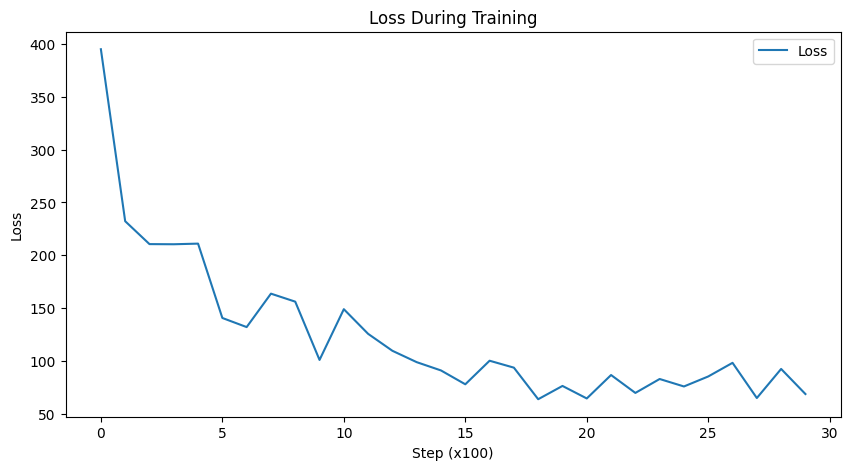

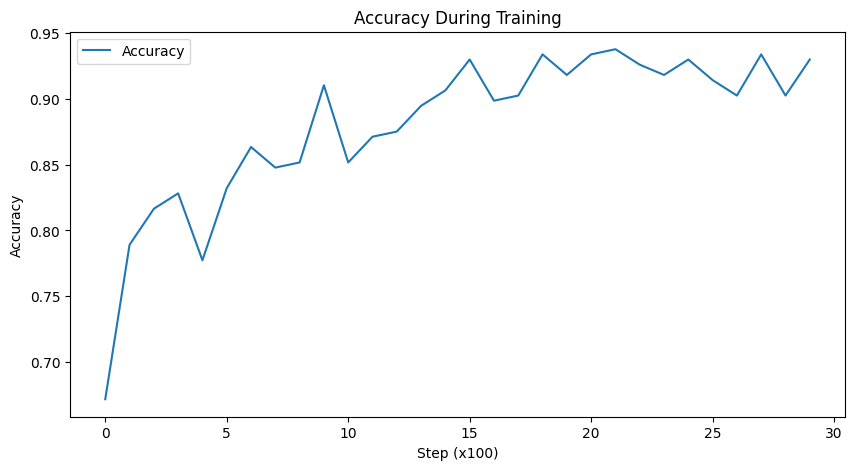

In [13]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_history, label="Loss")
plt.xlabel("Step (x100)")
plt.ylabel("Loss")
plt.title("Loss During Training")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(accuracy_history, label="Accuracy")
plt.xlabel("Step (x100)")
plt.ylabel("Accuracy")
plt.title("Accuracy During Training")
plt.legend()
plt.show()


In [14]:
test_pred = neural_net(x_test)
test_acc = accuracy(test_pred, y_test)
print(f"Test Accuracy: {test_acc.numpy()}")

from sklearn.metrics import classification_report
y_pred_classes = tf.argmax(test_pred, axis=1).numpy()
print(classification_report(y_test, y_pred_classes))

Test Accuracy: 0.8996999859809875
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       980
           1       0.97      0.97      0.97      1135
           2       0.87      0.90      0.89      1032
           3       0.87      0.87      0.87      1010
           4       0.90      0.89      0.90       982
           5       0.88      0.83      0.85       892
           6       0.93      0.93      0.93       958
           7       0.88      0.92      0.90      1028
           8       0.84      0.87      0.85       974
           9       0.91      0.86      0.88      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



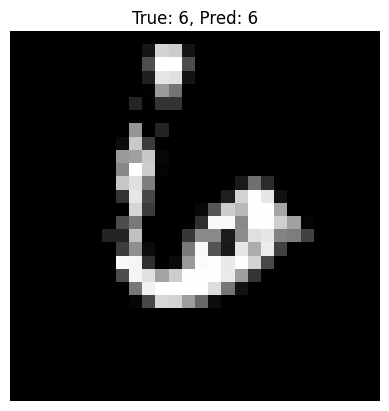

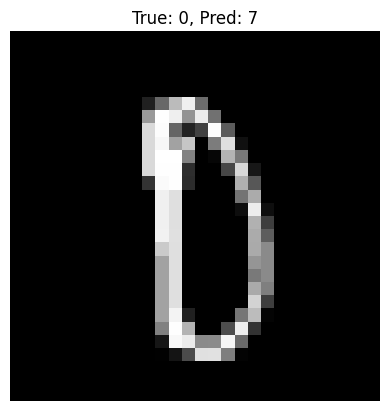

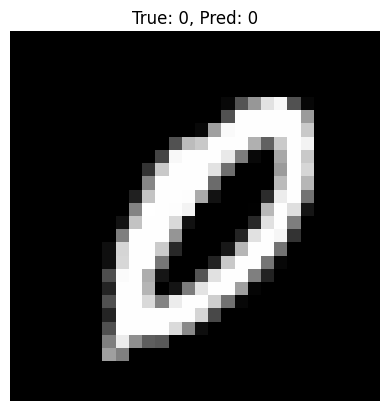

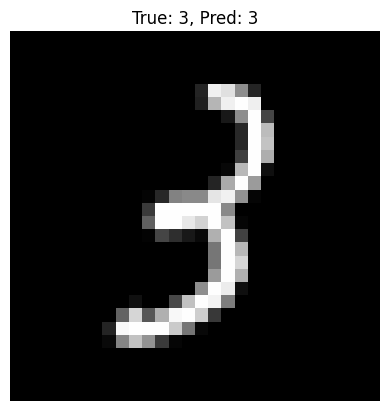

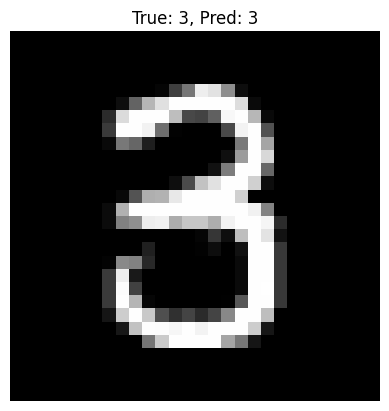

In [15]:
import random

for _ in range(5):
    idx = random.randint(0, x_test.shape[0] - 1)
    image = x_test[idx].reshape(28, 28)
    label = y_test[idx]
    pred_label = tf.argmax(test_pred[idx]).numpy()

    plt.imshow(image, cmap="gray")
    plt.title(f"True: {label}, Pred: {pred_label}")
    plt.axis("off")
    plt.show()




In [ ]:
Висновки
Якщо точність на тестовій вибірці висока (>90%), нейромережа добре справляється із завданням.
Помилки зазвичай трапляються через схожість рукописних цифр.
Можна покращити результати, використовуючи більше прихованих шарів, змінюючи функцію активації чи підбираючи оптимальний learning rate.